In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from sklearn.metrics import r2_score, mean_absolute_error
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rc('font',family='Times New Roman')

In [11]:
# 数据读取
pm = pd.read_csv('./Data/PRSA_Data/Data_Aotizhongxin.csv', header=0, infer_datetime_format=True, engine='c', parse_dates=['datetime'], index_col=['datetime'])

In [12]:
# 异常值处理：选择IQR处理
def IQR(data, new_data):
    for i in range(len(np.array(data.columns))):
        df_25 = data.iloc[:,i].quantile(0.25)
        df_75 = data.iloc[:,i].quantile(0.75)
        IQR = df_75 - df_25
        lower_limit = df_25 - 1.5*IQR
        upper_limit = df_75 + 1.5*IQR
        new_data.iloc[:,i] = data.iloc[:,i][(data.iloc[:,i]>lower_limit) & (data.iloc[:,i]<upper_limit)]
        
pm_data = pm.copy()
IQR(pm, pm_data)

In [13]:
# 缺失值处理：这里采用线性插值
pm_data = pm.interpolate()

In [14]:
pm_data.isna().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
WSPM     0
dtype: int64

In [15]:
# 划分训练集和测试集
train_rate = 0.7
train_num = int(train_rate*len(np.array(pm_data.iloc[:,0])))
train_data = pm_data.iloc[:train_num,:]
test_data = pm_data.iloc[train_num:,:]

In [16]:
# 对PM2.5进行预测
train_data_x = train_data.iloc[:,2:-1].values
train_data_y = train_data.iloc[:,0].values
test_data_x = test_data.iloc[:,2:-1].values
test_data_y = test_data.iloc[:,0].values

#### 1.多元时间序列SARIMAX

In [47]:
# 模型训练：ARIMAX不需要对数据进行标准化
# 模型参数调整：https://blog.csdn.net/htuhxf/article/details/106560206
ARIMAX_model = sm.tsa.statespace.SARIMAX(train_data_y, exog = train_data_x, order=(0,0,1),seasonal_order=(0, 0, 0, 0),trend='n').fit(disp=0)

In [48]:
ARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                24544
Model:               SARIMAX(0, 0, 1)   Log Likelihood             -117334.243
Date:                Thu, 01 Jun 2023   AIC                         234688.485
Time:                        21:23:30   BIC                         234769.567
Sample:                             0   HQIC                        234714.752
                              - 24544                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4728      0.012     40.708      0.000       0.450       0.496
x2             0.6824      0.010     71.175      0.000       0.664       0.701
x3             0.0321      0.000    233.842      0.000       0.032       0.032
x4             0.2617      0.008     31.436      0.000       0.245       0.278
x5            -1.1303      0.073    -15.505      0.000      -1.273      -0.987
x6            -0.0135      0.001    -10.343      0.000      -0.016      -0.011
x7             1.8601      0.055     33.761      0.000       1.752       1.968
x8            -0.1681      0.133     -1.261      0.207      -0.429       0.093
ma.L1          0.7714      0.002    424.789      0.000       0.768       0.775
sigma2       905.4300      3.589    252.284      0.000     898.396     912.464
===================================================================================
Ljung-Box (L1) (Q):                6956.91   Jarque-Bera (JB):            369985.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                             1.02
Prob(H) (two-sided):                  0.03   Kurtosis:                        21.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# 模型预测
test_pre = ARIMAX_model.forecast(steps=len(np.array(test_data.iloc[:,0])), exog=test_data_x)

NSE = 0.7576664305774723
MAE = 28.380984049199725


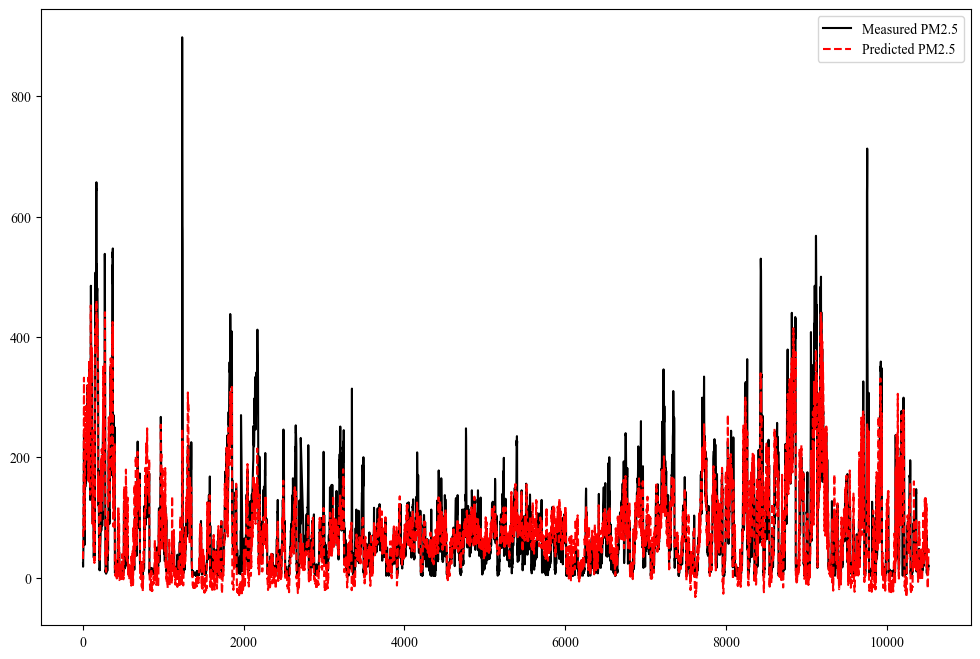

In [50]:
plt.figure(figsize=(12,8))
plt.plot(np.ravel(test_data_y), label='Measured PM2.5', c='k')
plt.plot(test_pre, label='Predicted PM2.5', c='r', linestyle='--')
plt.legend()
print('NSE =',r2_score(np.ravel(test_data_y),test_pre))
print('MAE =',mean_absolute_error(np.ravel(test_data_y),test_pre))